# Test User Afib Detection

I found a volunteer to donate their fitbit heart rate data and a log of their atrial fibulation (afib) episodes, this notebook will endeavor to build a detector that can automatically recognize afib episodes.

In [1]:
import pandas as pd
import json

import psycopg2
conn = psycopg2.connect(host='ec2-107-20-166-28.compute-1.amazonaws.com',
                        user='rbhciitblovwew',
                        database='db274el0c49tdu')

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(rc={"figure.figsize": (16, 9)})
sns.set(style="whitegrid")

In [46]:
query = """
SELECT * FROM activity_journal_minutes WHERE user_id = 2
"""
comb_journals = pd.read_sql(query, conn, parse_dates=['step_dttm', 'heart_dttm', 'journal_date'])
comb_journals.head()

,user_id,steps,bpm,journal_date,step_dttm,heart_dttm
0,2,0,56,2016-07-11,2016-07-11 00:00:00,2016-07-11 00:00:00
1,2,0,56,2016-07-11,2016-07-11 00:01:00,2016-07-11 00:01:00
2,2,0,57,2016-07-11,2016-07-11 00:02:00,2016-07-11 00:02:00
3,2,0,57,2016-07-11,2016-07-11 00:03:00,2016-07-11 00:03:00
4,2,0,57,2016-07-11,2016-07-11 00:04:00,2016-07-11 00:04:00


In [3]:
# NOTE (FIXME): Is the heart rate data reported in UTC and this log in PST?
episode_log = [
    ['2016-08-08 02:00:00', '2016-08-08 05:07:00'],
    ['2016-09-02 21:15:00', '2016-09-03 02:15:00'],
    ['2016-10-20 16:30:00', '2016-10-20 18:30:00'],
    ['2016-11-07 16:30:00', '2016-11-07 19:00:00'],
    ['2016-12-14 15:15:00', '2016-12-14 17:45:00'],
    ['2016-12-24 03:20:00', '2016-12-24 06:00:00'],
    ['2016-12-26 08:00:00', '2016-12-26 09:45:00']
]

In [69]:
pd.to_datetime(episode_log[0][0]).tz_localize('US/Pacific').tz_convert(None)

Timestamp('2016-08-08 09:00:00')

In [70]:
# Label each record as in afib or not
comb_journals['afib'] = False

for log in episode_log:
    episode_start = pd.to_datetime(log[0]).tz_localize('US/Pacific').tz_convert(None)
    episode_end = pd.to_datetime(log[1]).tz_localize('US/Pacific').tz_convert(None)
    comb_journals['afib'][ (comb_journals['heart_dttm'] >= episode_start) &
                   (comb_journals['heart_dttm'] <  episode_end)
                 ] = True

    
comb_journals[comb_journals['afib'] == True].count()

/home/brycemcd/anaconda2/envs/typical_stack/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


user_id             1150
steps               1150
bpm                 1150
journal_date        1150
step_dttm           1150
heart_dttm          1150
afib                1150
hr_to_step_ratio    1150
dtype: int64

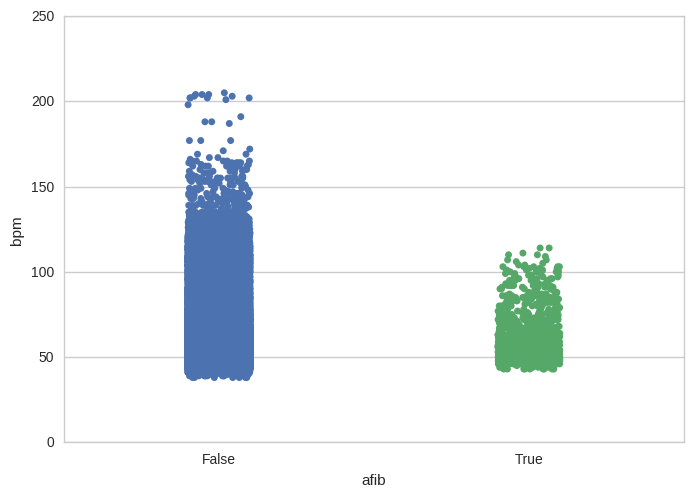

In [71]:
sns.stripplot(data=comb_journals, y='bpm', x='afib', jitter=True)
plt.show()

In [75]:
comb_journals[ comb_journals['bpm'] > 160 ]

,user_id,steps,bpm,journal_date,step_dttm,heart_dttm,afib,hr_to_step_ratio
108542,2,111,164,2016-10-27,2016-10-27 06:32:00,2016-10-27 06:32:00,False,1.464286
108543,2,110,165,2016-10-27,2016-10-27 06:33:00,2016-10-27 06:33:00,False,1.486486
108566,2,89,164,2016-10-27,2016-10-27 06:56:00,2016-10-27 06:56:00,False,1.822222
108567,2,85,165,2016-10-27,2016-10-27 06:57:00,2016-10-27 06:57:00,False,1.918605
108661,2,105,162,2016-10-27,2016-10-27 09:15:00,2016-10-27 09:15:00,False,1.528302
108670,2,111,165,2016-10-27,2016-10-27 09:24:00,2016-10-27 09:24:00,False,1.473214
108671,2,106,167,2016-10-27,2016-10-27 09:25:00,2016-10-27 09:25:00,False,1.560748
108672,2,109,163,2016-10-27,2016-10-27 09:26:00,2016-10-27 09:26:00,False,1.481818
108673,2,86,162,2016-10-27,2016-10-27 09:27:00,2016-10-27 09:27:00,False,1.862069
108674,2,112,164,2016-10-27,2016-10-27 09:28:00,2016-10-27 09:28:00,False,1.451327


Heart rate alone does not seem to separate the data very well. For graphical purposes, I'll look at the relationship of steps and heart rate.

In [73]:
comb_journals['hr_to_step_ratio'] = comb_journals['bpm'] / (comb_journals['steps'] + 1) # +1 avoid div by zero errors
comb_journals.head()

,user_id,steps,bpm,journal_date,step_dttm,heart_dttm,afib,hr_to_step_ratio
0,2,0,56,2016-07-11,2016-07-11 00:00:00,2016-07-11 00:00:00,False,56.0
1,2,0,56,2016-07-11,2016-07-11 00:01:00,2016-07-11 00:01:00,False,56.0
2,2,0,57,2016-07-11,2016-07-11 00:02:00,2016-07-11 00:02:00,False,57.0
3,2,0,57,2016-07-11,2016-07-11 00:03:00,2016-07-11 00:03:00,False,57.0
4,2,0,57,2016-07-11,2016-07-11 00:04:00,2016-07-11 00:04:00,False,57.0


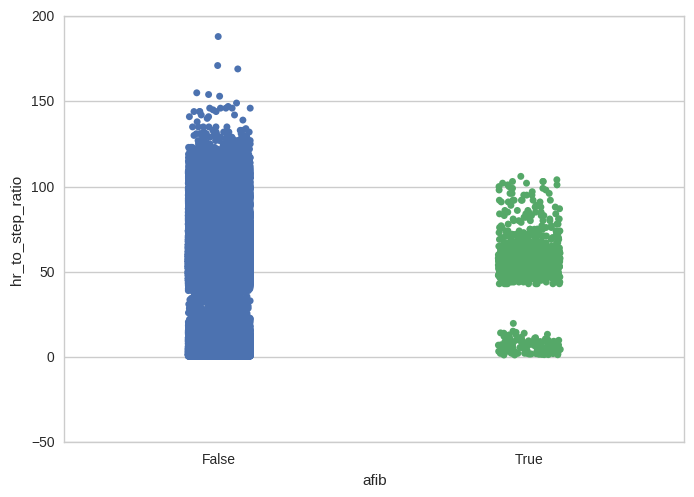

In [74]:
sns.stripplot(data=comb_journals, y='hr_to_step_ratio', x='afib', jitter=True)
plt.show()

TODO: There's not much separation in the data and given that some of the labeled afib events show bpm < 60, I think there is a problem matching the event log to the event in the fitbit dataset.

+ Look at API docs to see if step AND bpm data coming from fitbit are both reported in UTC
+ Make sure event log and fitbit data is paired in the same timezone
+ Get feedback from user about what's happening when bpm is > 130 && an event is not reported